In [69]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


### Load Data

In [81]:
train_data=pd.read_csv("/kaggle/input/playground-series-s5e7/train.csv")
test_data=pd.read_csv("/kaggle/input/playground-series-s5e7/test.csv")
train_data.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [82]:
train_data = train_data.drop_duplicates()

In [ ]:
train_data.shape

In [ ]:
test_data.shape

In [ ]:
train_data.describe()


In [ ]:
train_data.info()

In [83]:
train_data.drop('id', axis=1, inplace=True)
test_data.drop('id', axis=1, inplace=True)

In [73]:
# Check for missing values in the training data
print("Missing values in training data:")
print(train_data.isnull().sum())

# Check for missing values in the test data
print("\nMissing values in test data:")
print(test_data.isnull().sum())

Missing values in training data:
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

Missing values in test data:
Time_spent_Alone             425
Stage_fear                   598
Social_event_attendance      397
Going_outside                466
Drained_after_socializing    432
Friends_circle_size          350
Post_frequency               408
dtype: int64


In [84]:
num_cols = train_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
obj_cols = train_data.select_dtypes(include=['object']).columns.tolist()

In [85]:
obj_cols.remove('Personality')

In [ ]:
train_data["Stage_fear"].unique()

In [ ]:
train_data["Drained_after_socializing"].unique()

### Data Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
plt.figure(figsize=(10, 5))
for i, col in enumerate(obj_cols):
    plt.subplot(1, 2, i + 1)
    sns.countplot(x=train_data[col])
    plt.title(f'Distribution of {col}')
    plt.xticks([0, 1], ['No', 'Yes']) 
plt.tight_layout()
plt.show()

In [ ]:
train_data[obj_cols].describe()

In [ ]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=train_data[col])
    plt.title(f'Box plot of {col}')
plt.tight_layout()
plt.show()

### Handling Missing Values

In [86]:
for col in obj_cols:
    # Map 'Yes' to 1, 'No' to 0, and NaN/others to NaN for imputation
    mapping = {'Yes': 1, 'No': 0}
    train_data[col] = train_data[col].map(mapping)
    test_data[col] = test_data[col].map(mapping)

    # Impute missing values with the mode from the training set
    mode_val_train = train_data[col].mode()[0] 
    train_data[col].fillna(mode_val_train, inplace=True)
    test_data[col].fillna(mode_val_train, inplace=True) 

/tmp/ipykernel_36/2925108889.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[col].fillna(mode_val_train, inplace=True)
/tmp/ipykernel_36/2925108889.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [87]:
for col in num_cols:
    # Ensure they are numeric, coercing errors to NaN
    train_data[col] = pd.to_numeric(train_data[col], errors='coerce')
    test_data[col] = pd.to_numeric(test_data[col], errors='coerce')

    # Impute missing values with the median from the training set
    median_val_train = train_data[col].median()
    train_data[col].fillna(median_val_train, inplace=True)
    test_data[col].fillna(median_val_train, inplace=True) 


/tmp/ipykernel_36/1271741955.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[col].fillna(median_val_train, inplace=True)
/tmp/ipykernel_36/1271741955.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

In [88]:
# Check for missing values in the training data
print("Missing values in training data:")
print(train_data.isnull().sum())

# Check for missing values in the test data
print("\nMissing values in test data:")
print(test_data.isnull().sum())

Missing values in training data:
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64

Missing values in test data:
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
dtype: int64


In [11]:
train_data.describe()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
count,18524.000000,18524.000000,18524.000000,18524.000000,18524.000000,18524.000000,18524.000000
mean,3.064673,0.217124,5.248219,4.040812,0.219283,7.996923,4.983319
std,2.919057,0.412299,2.665002,1.979312,0.413772,4.101561,2.779172
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,3.000000,3.000000,0.000000,5.000000,3.000000
50%,2.000000,0.000000,5.000000,4.000000,0.000000,8.000000,5.000000
75%,4.000000,0.000000,7.000000,6.000000,0.000000,11.000000,7.000000
max,11.000000,1.000000,10.000000,7.000000,1.000000,15.000000,10.000000


In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           18524 non-null  float64
 1   Stage_fear                 18524 non-null  float64
 2   Social_event_attendance    18524 non-null  float64
 3   Going_outside              18524 non-null  float64
 4   Drained_after_socializing  18524 non-null  float64
 5   Friends_circle_size        18524 non-null  float64
 6   Post_frequency             18524 non-null  float64
 7   Personality                18524 non-null  object 
dtypes: float64(7), object(1)
memory usage: 1.1+ MB


In [12]:
print(obj_cols)

['Stage_fear', 'Drained_after_socializing']


### Outlier Detection and Handling using IQR Method

In [89]:
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_before = df[(df[column] < lower_bound) | (df[column] > upper_bound)].shape[0]
    print(f"Column: {column}, Outliers before capping: {outliers_before}")

    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

In [91]:
for col in num_cols:
    train_df = cap_outliers_iqr(train_data.copy(), col) 


Column: Time_spent_Alone, Outliers before capping: 1653
Column: Social_event_attendance, Outliers before capping: 0
Column: Going_outside, Outliers before capping: 0
Column: Friends_circle_size, Outliers before capping: 0
Column: Post_frequency, Outliers before capping: 0


In [92]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           18524 non-null  float64
 1   Stage_fear                 18524 non-null  float64
 2   Social_event_attendance    18524 non-null  float64
 3   Going_outside              18524 non-null  float64
 4   Drained_after_socializing  18524 non-null  float64
 5   Friends_circle_size        18524 non-null  float64
 6   Post_frequency             18524 non-null  float64
 7   Personality                18524 non-null  object 
dtypes: float64(7), object(1)
memory usage: 1.1+ MB


In [93]:
mapping = {'Introvert': 1, 'Extrovert': 0}
train_df["Personality"] = train_data["Personality"].map(mapping)


In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           18524 non-null  float64
 1   Stage_fear                 18524 non-null  float64
 2   Social_event_attendance    18524 non-null  float64
 3   Going_outside              18524 non-null  float64
 4   Drained_after_socializing  18524 non-null  int64  
 5   Friends_circle_size        18524 non-null  float64
 6   Post_frequency             18524 non-null  float64
 7   Personality                18524 non-null  int64  
dtypes: float64(6), int64(2)
memory usage: 1.1 MB


In [94]:
test_data.info()
test_df=test_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6175 entries, 0 to 6174
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           6175 non-null   float64
 1   Stage_fear                 6175 non-null   float64
 2   Social_event_attendance    6175 non-null   float64
 3   Going_outside              6175 non-null   float64
 4   Drained_after_socializing  6175 non-null   float64
 5   Friends_circle_size        6175 non-null   float64
 6   Post_frequency             6175 non-null   float64
dtypes: float64(7)
memory usage: 337.8 KB


### Feature Engineering

In [106]:
train_df["sociality"] = train_df["Friends_circle_size"]*train_df["Post_frequency"]*train_df["Social_event_attendance"]
test_df["sociality"] = test_df["Friends_circle_size"]*test_df["Post_frequency"]*test_df["Social_event_attendance"]

In [107]:
train_df["aloneratio"] = train_df["Time_spent_Alone"]/(train_df["Post_frequency"]+1)
test_df["aloneratio"] = test_df["Time_spent_Alone"]/(test_df["Post_frequency"]+1)

In [98]:
# median_val_train = train_df["aloneratio"].median()
# train_df["aloneratio"].fillna(median_val_train, inplace=True)
# test_df["aloneratio"].fillna(median_val_train, inplace=True) 

/tmp/ipykernel_36/3230930735.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df["aloneratio"].fillna(median_val_train, inplace=True)
/tmp/ipykernel_36/3230930735.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

In [108]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           18524 non-null  float64
 1   Stage_fear                 18524 non-null  float64
 2   Social_event_attendance    18524 non-null  float64
 3   Going_outside              18524 non-null  float64
 4   Drained_after_socializing  18524 non-null  float64
 5   Friends_circle_size        18524 non-null  float64
 6   Post_frequency             18524 non-null  float64
 7   Personality                18524 non-null  int64  
 8   sociality                  18524 non-null  float64
 9   aloneratio                 18524 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.4 MB


### Evaluation

In [109]:
X = train_df.drop(['Personality'], axis=1) 
y = train_df['Personality']

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report,confusion_matrix, roc_auc_score, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns

In [111]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 

In [103]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14819 entries, 12652 to 7589
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           14819 non-null  float64
 1   Stage_fear                 14819 non-null  float64
 2   Social_event_attendance    14819 non-null  float64
 3   Going_outside              14819 non-null  float64
 4   Drained_after_socializing  14819 non-null  float64
 5   Friends_circle_size        14819 non-null  float64
 6   Post_frequency             14819 non-null  float64
 7   sociality                  14819 non-null  float64
 8   aloneratio                 14819 non-null  float64
dtypes: float64(9)
memory usage: 1.1 MB


In [112]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n===== {name} =====")
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid()


### Random forest classifier


===== Random Forest =====
              precision    recall  f1-score   support

           0     0.9820    0.9734    0.9776      2740
           1     0.9262    0.9492    0.9376       965

    accuracy                         0.9671      3705
   macro avg     0.9541    0.9613    0.9576      3705
weighted avg     0.9674    0.9671    0.9672      3705

Confusion Matrix:
[[2667   73]
 [  49  916]]
ROC AUC: 0.9685265307666124


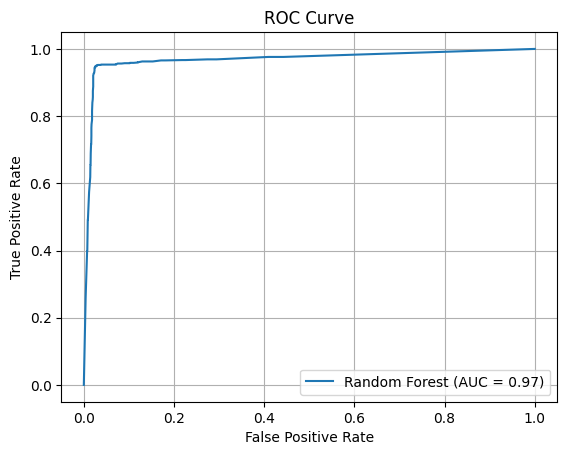

In [113]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

evaluate_model("Random Forest", rf_model, X_val, y_val)
plt.legend()
plt.show()


### Gradient Boosting


===== Gradient Boosting =====
              precision    recall  f1-score   support

           0     0.9824    0.9781    0.9802      2740
           1     0.9386    0.9503    0.9444       965

    accuracy                         0.9709      3705
   macro avg     0.9605    0.9642    0.9623      3705
weighted avg     0.9710    0.9709    0.9709      3705

Confusion Matrix:
[[2680   60]
 [  48  917]]
ROC AUC: 0.97248421012821


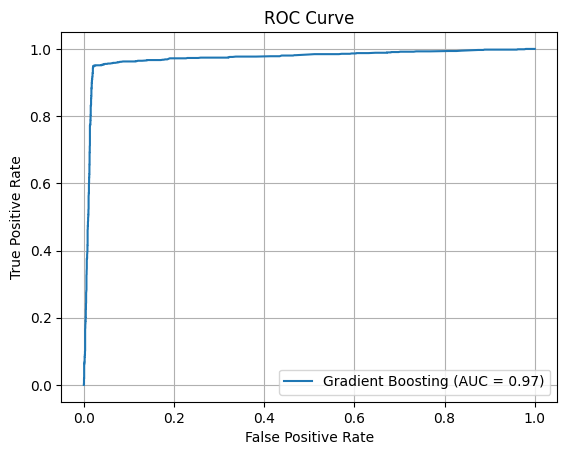

In [115]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

evaluate_model("Gradient Boosting", gb_model, X_val, y_val)
plt.legend()
plt.show()


### XGB


===== XGBoost =====
              precision    recall  f1-score   support

           0     0.9821    0.9788    0.9804      2740
           1     0.9405    0.9492    0.9448       965

    accuracy                         0.9711      3705
   macro avg     0.9613    0.9640    0.9626      3705
weighted avg     0.9712    0.9711    0.9712      3705

Confusion Matrix:
[[2682   58]
 [  49  916]]
ROC AUC: 0.9680509436103022


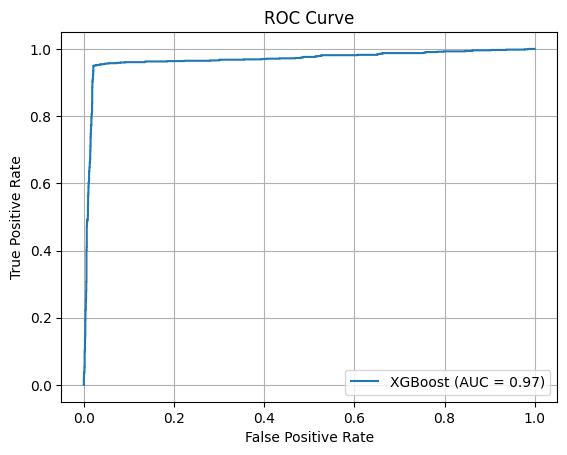

In [116]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

evaluate_model("XGBoost", xgb_model, X_val, y_val)
plt.legend()
plt.show()


### Light BGM

[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 334
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260476 -> initscore=-1.043494
[LightGBM] [Info] Start training from score -1.043494

===== LightGBM =====
              precision    recall  f1-score   support

           0     0.9824    0.9788    0.9806      2740
           1     0.9405    0.9503    0.9454       965

    accuracy                         0.9714      3705
   macro avg     0.9615    0.9645    0.9630      3705
weighted avg     0.9715    0.9714    0.9714      3705

Confusion Matrix:
[[2682   58]
 [  48  917]]
ROC AUC: 0.9695295185507355


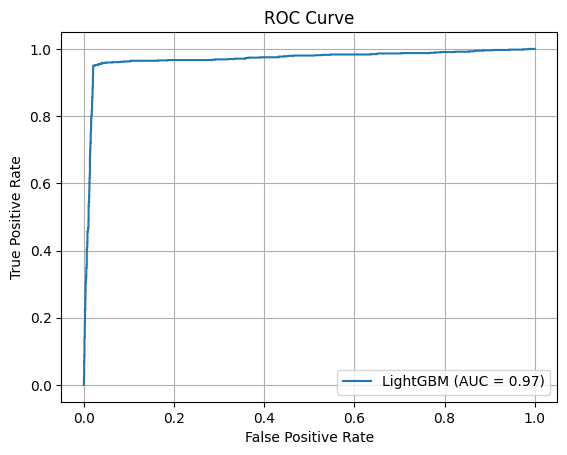

In [117]:
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train, y_train)

evaluate_model("LightGBM", lgbm_model, X_val, y_val)
plt.legend()
plt.show()


### Cat Boost


===== CatBoost =====
              precision    recall  f1-score   support

           0     0.9824    0.9792    0.9808      2740
           1     0.9415    0.9503    0.9458       965

    accuracy                         0.9717      3705
   macro avg     0.9620    0.9647    0.9633      3705
weighted avg     0.9718    0.9717    0.9717      3705

Confusion Matrix:
[[2683   57]
 [  48  917]]
ROC AUC: 0.9703435951741612


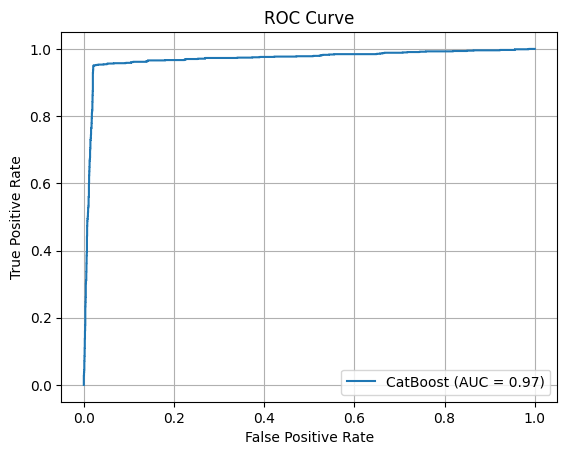

In [118]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)

evaluate_model("CatBoost", cat_model, X_val, y_val)
plt.legend()
plt.show()


### Voting Classifier


===== Voting Classifier =====
              precision    recall  f1-score   support

           0     0.9824    0.9788    0.9806      2740
           1     0.9405    0.9503    0.9454       965

    accuracy                         0.9714      3705
   macro avg     0.9615    0.9645    0.9630      3705
weighted avg     0.9715    0.9714    0.9714      3705

Confusion Matrix:
[[2682   58]
 [  48  917]]
ROC AUC: 0.9706385915812563


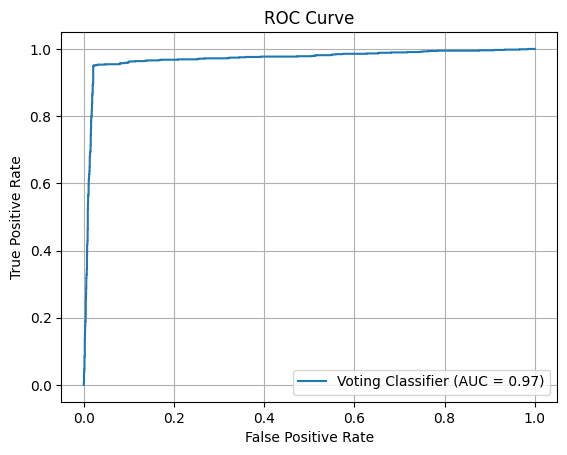

In [119]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('gb', gb_model),
        ('xgb', xgb_model)
    ],
    voting='soft'
)
voting_model.fit(X_train, y_train)

evaluate_model("Voting Classifier", voting_model, X_val, y_val)
plt.legend()
plt.show()


### Stacking Classifier

[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 334
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260476 -> initscore=-1.043494
[LightGBM] [Info] Start training from score -1.043494
[LightGBM] [Info] Number of positive: 3088, number of negative: 8767
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 330
[LightGBM] [Info] Number of data points in the train set: 11855, number of used features: 9
[LightGBM] [Info] [binary

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



===== Stacking Classifier =====
              precision    recall  f1-score   support

           0     0.9821    0.9792    0.9806      2740
           1     0.9414    0.9492    0.9453       965

    accuracy                         0.9714      3705
   macro avg     0.9617    0.9642    0.9630      3705
weighted avg     0.9715    0.9714    0.9714      3705

Confusion Matrix:
[[2683   57]
 [  49  916]]
ROC AUC: 0.9626547785635944


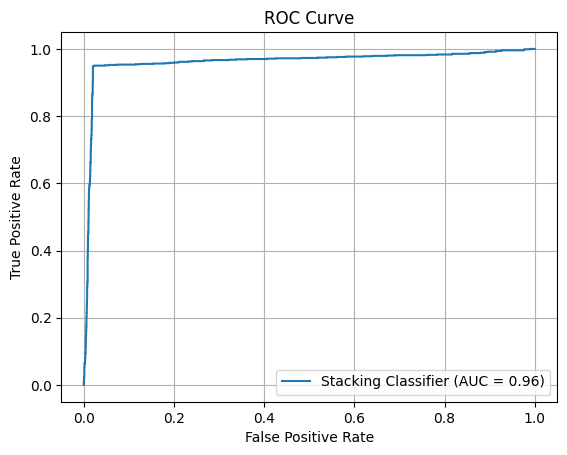

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

stacking_model = StackingClassifier(
    estimators=[
        ('lgbm', lgbm_model),
        ('cat', cat_model),
        ('xgb', xgb_model)
    ],
    final_estimator=LogisticRegression(),
    passthrough=True
)
stacking_model.fit(X_train, y_train)

evaluate_model("Stacking Classifier", stacking_model, X_val, y_val)
plt.legend()
plt.show()


### Predictions

In [123]:
test_data.shape

(6175, 9)

In [125]:
X_train.shape

(14819, 9)

In [145]:
final_model = StackingClassifier(
    estimators=[
        ('lgbm', lgbm_model),
        ('cat', cat_model),
        ('xgb', xgb_model)
    ],
    final_estimator=LogisticRegression(),
    passthrough=True
)

final_model.fit(X, y)

[LightGBM] [Info] Number of positive: 4825, number of negative: 13699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 18524, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260473 -> initscore=-1.043512
[LightGBM] [Info] Start training from score -1.043512
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 333
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 9
[LightGBM] [Info] [binar

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(estimators=[('lgbm', LGBMClassifier(random_state=42)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x79ea24115990>),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logl...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))],
                   final_estimator=LogisticRegression(), passthrough=True)

In [146]:
predictions = final_model.predict(test_data)

### Submission

In [147]:
submission = pd.read_csv('/kaggle/input/playground-series-s5e7/sample_submission.csv')
submission

,id,Personality
0,18524,Extrovert
1,18525,Extrovert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Extrovert
...,...,...
6170,24694,Extrovert
6171,24695,Extrovert
6172,24696,Extrovert
6173,24697,Extrovert


In [148]:
submission['Personality'] = predictions
submission

,id,Personality
0,18524,0
1,18525,1
2,18526,0
3,18527,0
4,18528,1
...,...,...
6170,24694,0
6171,24695,1
6172,24696,0
6173,24697,0


In [149]:
mapping = {1:'Introvert', 0:'Extrovert'}
submission["Personality"] = submission["Personality"].map(mapping)

In [150]:
submission.to_csv("submission_stacking_classifier.csv",index=False)